# Parameters for DRN network model GIF units

This document summarizes parameters extracted from GIFs fitted to 12 identified DRN 5HT neurons injected with 50ms OU noise which passed quality control.

**Note:** Model file is to large to track with git, so run `analysis/regression_tinkering/fit_michaelmod.py` to re-generate model if needed.

## Model definition

### Subthreshold dynamics
$$ C \frac{dV}{dt} = -g_l (V(t) - E_l) - I_{AHP}(t) + I_{inj}(t) $$

### Spike-triggered filters
Sum of $N$ exponentials of the form 
$$ \kappa = \sum_{i=1}^N A_i \exp \left[\frac{-(t - t_{spk})}{\tau_i} \right], t > t_{spk}. $$
We use a quadruple exponential for the AHP and a triple exponential for the threshold movement. In a typical implementation, each time a spike is fired a discretized version of $\kappa$ of length $T$ is added to the vector of eg $I_{AHP}$ for a given neuron going forward from roughly $t$ to $t + T$.

### Spiking process
Inhomogenous Poisson process with rate parameter
$$ \lambda(t) = \lambda_0 \exp \left[ \frac{V(t) - V_T(t)}{\Delta V} \right], $$ where $\lambda_0 = 10^{-4}$ spks/timestep (assuming $\Delta t$ = 0.1ms). We can then find the probability of spiking at each timestep $P_{spk}(t) = 1 - e^{-\lambda(t)}.$

## Import modules

In [1]:
from __future__ import division

import os; os.chdir(os.path.join('..', '..'))
print os.getcwd()

/Users/eharkin/Documents/School/Grad work/Thesis/Experiments/GIF fitting/GIF fitting project/GIFFittingToolbox


In [2]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%config InlineBackend.figure_format='retina'

## Load pre-fitted models

In [3]:
MOD_PATH = os.path.join('data', 'models', '5HT')

with open(os.path.join(MOD_PATH, '5HT_michaelmod.mod'), 'rb') as f:
    GIFs = pickle.load(f)
    f.close()

## Get model coefficients

In [4]:
params = {
    'gl': [],
    'El': [],
    'C': [],
    'Tref': [],
    'Vt_star': [],
    'Vr': [],
    'DV': [],
    'eta_coeffs': [],
    'eta_timescales': [],
    'gamma_coeffs': [],
    'gamma_timescales': []
}

for mod in GIFs:
    
    for attr_name in ['gl', 'El', 'C', 'Tref', 'Vt_star', 'Vr', 'DV']:
        params[attr_name].append(getattr(mod, attr_name))
    
    params['eta_coeffs'].append(mod.eta.getCoefficients())
    params['eta_timescales'].append(mod.eta.taus)
    
    params['gamma_coeffs'].append(mod.gamma.getCoefficients())
    params['gamma_timescales'].append(mod.gamma.taus)
    
params = pd.DataFrame(params)

In [5]:
params.head()

,C,DV,El,Tref,Vr,Vt_star,eta_coeffs,eta_timescales,gamma_coeffs,gamma_timescales,gl
0,0.099399,6.401344,-64.679411,6.5,-53.578397,-56.237069,"[0.04821677916338659, 0.02681994067994529, 0.0...","[3.0, 30.0, 300.0, 3000.0]","[-9.979617409427505, 2.7834032536599, 5.912647...","[30.0, 300.0, 3000.0]",0.001106
1,0.115566,2.354318,-65.183422,6.5,-56.140457,-49.298184,"[0.004714849781462479, 0.05763395059684705, 0....","[3.0, 30.0, 300.0, 3000.0]","[150.06253817094915, 7.509245641252141, 0.3935...","[30.0, 300.0, 3000.0]",0.002279
2,0.094376,3.918827,-63.897835,6.5,-55.901602,-46.770601,"[-0.031796695453305664, 0.059521968591513166, ...","[3.0, 30.0, 300.0, 3000.0]","[237.0377021396467, 5.629415212247567, 0.07121...","[30.0, 300.0, 3000.0]",0.001668
3,0.105813,3.676286,-78.017858,6.5,-55.912411,-54.438679,"[0.09313386197424596, 0.01178096186742898, 0.0...","[3.0, 30.0, 300.0, 3000.0]","[143.02467160089816, 46.02837638174735, 0.5566...","[30.0, 300.0, 3000.0]",0.001483
4,0.057387,4.504267,-59.126747,6.5,-50.669208,-52.748465,"[0.07263923239220263, 0.03241157139336846, 0.0...","[3.0, 30.0, 300.0, 3000.0]","[10.427579402857122, 6.590131098729741, 0.0336...","[30.0, 300.0, 3000.0]",0.001353


## Print parameter estimates

I assume you'll just want to use the mean of each parameter estimate in your implementation, but in case you want to put in a bit of parameter noise to linearize things I'll print the SDs too.

### Scalar parameters

- $C$ membrane capacitance (nF)
- $g_l$ leak conductance (nS)
- $E_l$ equilibrium potential of leak conductance (mV)
- $T_{ref}$ length of refractory period (ms)
- $V_T^*$ stochastic threshold (mV)
- $V_r$ post-spike voltage reset (mV)

In [6]:
print '{:>10}{:>10}{:>10}\n'.format('Parameter', 'Mean', 'SD')
for param_name in ['C', 'gl', 'El', 'Tref', 'Vt_star', 'Vr', 'DV']:
    print '{:>10}{:>10.4f}{:>10.4f}'.format(
        param_name, params[param_name].mean(), params[param_name].std()
    )

 Parameter      Mean        SD

         C    0.0876    0.0263
        gl    0.0014    0.0004
        El  -68.0652   10.1053
      Tref    6.5000    0.0000
   Vt_star  -52.3282    5.2972
        Vr  -54.0248    2.6428
        DV    4.3809    1.3601


Membrane time constant is usually around 50ms.

Note that $V_t^*$ is probably not a perfect estimate of the ideal static threshold. This is because $V_T$ is 'transiently' increased from $V_T^*$ by the spike-triggered threshold movement $\gamma$ after each spike. $V_T^*$ is therefore probably best interpreted as a lower bound on a static threshold (if you want to implement your model that way).

### Spike-triggered filters

Recall: Spike-triggered filters are defined as sums of $N$ exponentials $$ \sum_{i=1}^N A_i \exp \left[\frac{-(t - t_{spk})}{\tau_i} \right]. $$ The timescale $\tau_i$ of each exponential component $i$ is in ms and the amplitudes $A_i$ are given in **nA** or mV (this is to make more units cancel).

- $\eta$ spike triggered current (nA)
- $\gamma$ spike-triggered threshold movement (mV)

In [7]:
def solve_multiexp(timescales, amplitudes, T, dt = 0.1):
    """Solve a sum-of-exponentials kernel.
    
    Inputs:
        timescales (vector of floats)
            -- Time constants to use for each exponential component.
        amplitudes (vector of floats)
            -- Amplitude of each exponential component.
        T (float)
            -- Length of time over which to solve multiexponential.
        dt (float)
            -- Time resolution for solved exponential.
            
    Returns:
        t (vector of floats)
            -- Support vector.
        x (vector of floats)
            -- Amplitude at each timepoint.
    """
    
    assert len(timescales) == len(amplitudes), 'timescales and amplitudes must have same number of entries'
    
    t_vec = np.arange(0, T, dt)
    x = np.zeros_like(t_vec)
    
    for tau, A in zip(timescales, amplitudes):
        x += A * np.exp(-t_vec/tau)
        
    return t_vec, x

In [8]:
# Dict to hold mean coefficients.
mean_eta = {
    'taus': [],
    'amplis': []
}

# Temporarily convert param dataframe entries to lists.
eta_coeffs_tmp = np.array(params['eta_coeffs'].tolist())
eta_taus_tmp = np.array(params['eta_timescales'].tolist())

# Do the work.
print '{:^30}\n'.format('-- AHP COEFFS --')
print '{:>10}{:>10}{:>10}\n'.format('Tau', 'Mean', 'SD')
for i in range(eta_coeffs_tmp.shape[1]):
    
    mean_eta['taus'].append(eta_taus_tmp[:, i].mean())
    mean_eta['amplis'].append(eta_coeffs_tmp[:, i].mean())
    
    print '{:>10.4f}{:>10.4f}{:>10.4f}'.format(
        eta_taus_tmp[:, i].mean(), 
        eta_coeffs_tmp[:, i].mean(),
        eta_coeffs_tmp[:, i].std()
    )
    
del eta_taus_tmp, eta_coeffs_tmp

       -- AHP COEFFS --       

       Tau      Mean        SD

    3.0000    0.0281    0.0619
   30.0000    0.0333    0.0154
  300.0000    0.0210    0.0066
 3000.0000   -0.0002    0.0007


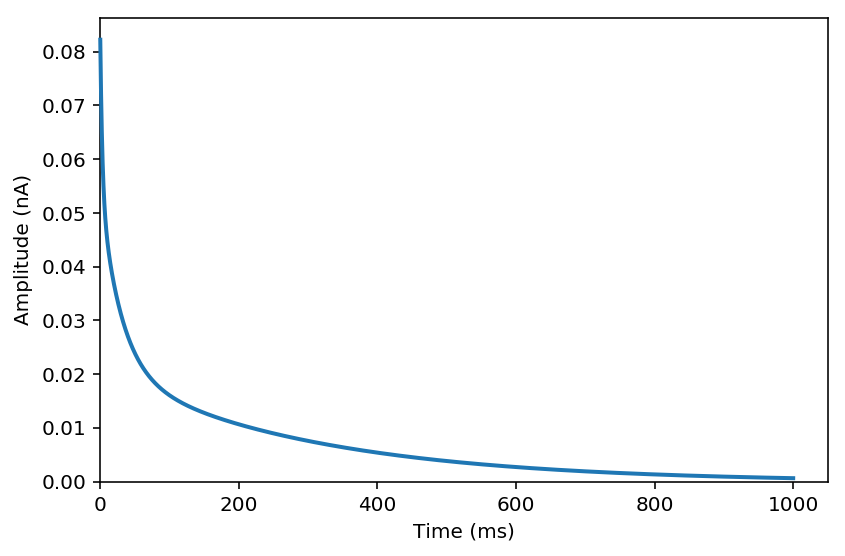

In [9]:
plt.plot(
    *solve_multiexp(mean_eta['taus'], mean_eta['amplis'], 1000.), 
    lw = 2, clip_on = False, zorder = 10
)
plt.ylim(0, plt.ylim()[1])
plt.xlim(0, plt.xlim()[1])
plt.ylabel('Amplitude (nA)')
plt.xlabel('Time (ms)')

plt.tight_layout()
plt.show()

Looks like the AHP is almost gone by 1s. This might mean you could precompute a 1s kernel and add it to an $\mathbf{I}_{AHP}$ matrix for the corresponding cell each time you get a spike. Could probably even drop the slowest exponential.

In [10]:
# Dict to hold mean coefficients.
mean_gamma = {
    'taus': [],
    'amplis': []
}

# Temporarily convert param dataframe entries to lists.
gamma_coeffs_tmp = np.array(params['gamma_coeffs'].tolist())
gamma_taus_tmp = np.array(params['gamma_timescales'].tolist())

# Do the work.
print '{:^30}\n'.format('-- THRESH MVT. COEFFS --')
print '{:>10}{:>10}{:>10}\n'.format('Tau', 'Mean', 'SD')
for i in range(gamma_coeffs_tmp.shape[1]):
    
    mean_gamma['taus'].append(gamma_taus_tmp[:, i].mean())
    mean_gamma['amplis'].append(gamma_coeffs_tmp[:, i].mean())
    
    print '{:>10.4f}{:>10.4f}{:>10.4f}'.format(
        gamma_taus_tmp[:, i].mean(), 
        gamma_coeffs_tmp[:, i].mean(),
        gamma_coeffs_tmp[:, i].std()
    )
    
del gamma_taus_tmp, gamma_coeffs_tmp

   -- THRESH MVT. COEFFS --   

       Tau      Mean        SD

   30.0000   51.8540   84.4130
  300.0000   13.3929   14.6552
 3000.0000    2.2290    2.2679


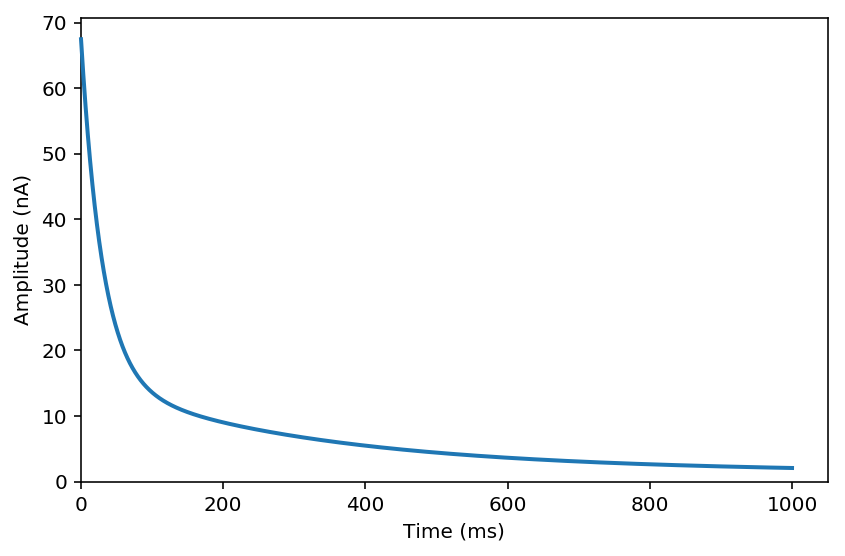

In [11]:
plt.plot(
    *solve_multiexp(mean_gamma['taus'], mean_gamma['amplis'], 1000.), 
    lw = 2, clip_on = False, zorder = 10
)
plt.ylim(0, plt.ylim()[1])
plt.xlim(0, plt.xlim()[1])
plt.ylabel('Amplitude (nA)')
plt.xlabel('Time (ms)')

plt.tight_layout()
plt.show()

The threshold movement is somewhat significant even after 1s.